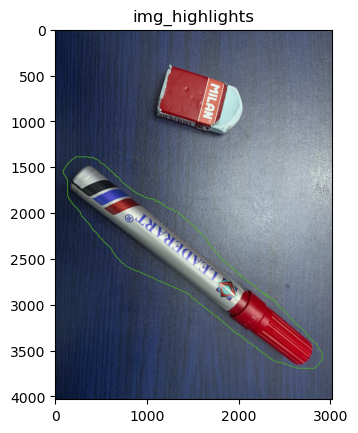

In [170]:
import numpy as np
import cv2
import os
from commonfunctions import *

img_highlights = cv2.imread("./eraser_marker_highlighted.jpg")
img = cv2.imread("./eraser_marker.jpg")
lost_found_box = cv2.imread("./marker_ruler_drawer.jpg")  # Image (correct box on arduino)

show_images([img_highlights], ["img_highlights"])


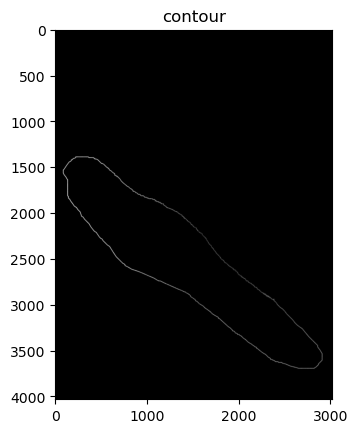

In [171]:
contour = cv2.subtract(img_highlights, img)
contour = cv2.cvtColor(contour, cv2.COLOR_BGR2GRAY)

pts_contour = np.where(contour > 3)
pts_contour = np.array([pts_contour[1], pts_contour[0]]).T

show_images([contour], ["contour"])

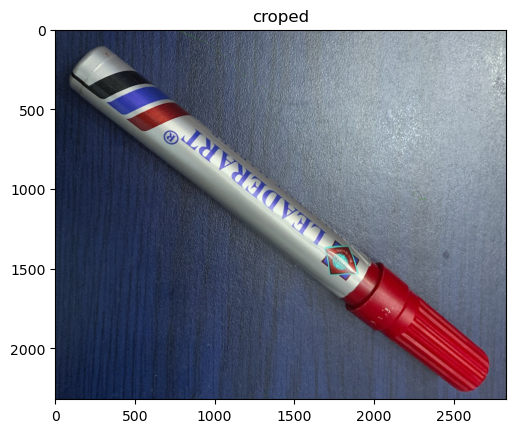

In [172]:
rect = cv2.boundingRect(pts_contour)
x, y, w, h = rect
croped = img[y : y + h, x : x + w].copy()
show_images([croped], ["croped"])

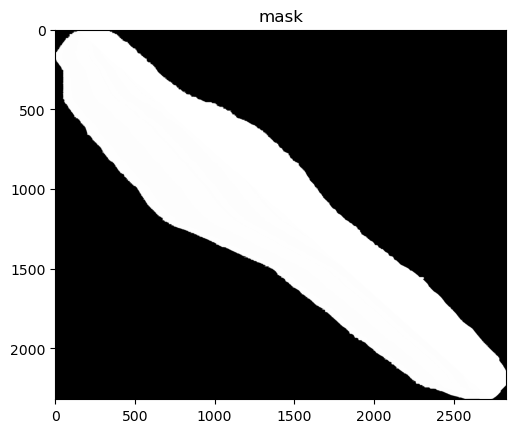

In [173]:
pts_contour = pts_contour - pts_contour.min(axis=0)

mask = np.zeros(croped.shape[:2], np.uint8)
cv2.drawContours(mask, [pts_contour], -1, (255, 255, 255), -1, cv2.LINE_AA)

show_images([mask ], ["mask"])

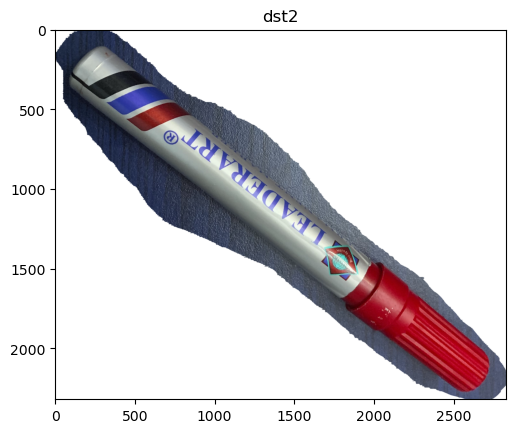

In [174]:
dst = cv2.bitwise_and(croped, croped, mask=mask)

## (4) add the white background
bg = np.ones_like(croped, np.uint8) * 255
cv2.bitwise_not(bg, bg, mask=mask)
dst2 = bg + dst
show_images([dst2], ["dst2"])

In [175]:
def applySift(train_image, test_image):
    train_image = cv2.cvtColor(train_image, cv2.COLOR_RGB2GRAY)
    test_image = cv2.cvtColor(test_image, cv2.COLOR_RGB2GRAY)
    sift = cv2.SIFT_create()
    kp1, desc1 = sift.detectAndCompute(train_image, None)
    kp2, desc2 = sift.detectAndCompute(test_image, None)

    bf = cv2.BFMatcher()
    matches = bf.knnMatch(desc1, desc2, k=2)

    # apply test
    good = []

    for m, n in matches:
        if m.distance < 0.75 * n.distance:
            good.append([m])

    img3 = cv2.drawMatchesKnn(
        train_image, kp1, test_image, kp2, good[:50], None, flags=2
    )
    show_images([img3])
    return

In [176]:
def find_matching_boxes(image, template, detector_method, params):
    """
    template: Lost object image
    image: box image
    detector_method: SIFT or ORB
    params: dictionary of parameters (max_matching_objects, SIFT_distance_threshold, best_matches_points)
    """
    # Parameters and their default values
    MAX_MATCHING_OBJECTS = params.get("max_matching_objects", 10)
    SIFT_DISTANCE_THRESHOLD = params.get("SIFT_distance_threshold", 0.65)
    BEST_MATCHES_POINTS = params.get("best_matches_points", 50)

    # Initialize the detector and matcher
    if detector_method == "SIFT":
        detector = cv2.SIFT_create()
        bf = cv2.BFMatcher()
    elif detector_method == "ORB":
        detector = cv2.ORB_create(fastThreshold=5, edgeThreshold=10)
        bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    else:
        raise ValueError("Unsupported detector method")

    # Find keypoints and descriptors for the template
    keypoints2, descriptors2 = detector.detectAndCompute(
        template, None
    )  # lost object image (keypoints and feature vectors)

    matched_boxes = []
    matching_img = image.copy()  # box image

    for i in range(MAX_MATCHING_OBJECTS):
        # Match descriptors
        keypoints1, descriptors1 = detector.detectAndCompute(
            matching_img, None
        )  # box image (keypoints and feature vectors)

        if detector_method == "SIFT":
            # Matching strategy for SIFT
            matches = bf.knnMatch(descriptors1, descriptors2, k=2)
            good_matches = [
                m
                for m, n in matches
                if m.distance < SIFT_DISTANCE_THRESHOLD * n.distance
            ]
            good_matches = sorted(good_matches, key=lambda x: x.distance)[
                :BEST_MATCHES_POINTS
            ]

        elif detector_method == "ORB":
            # Matching strategy for ORB
            matches = bf.match(descriptors1, descriptors2)
            matches = sorted(matches, key=lambda x: x.distance)
            good_matches = matches[:BEST_MATCHES_POINTS]

        else:
            raise ValueError("Unsupported detector method")

        # Extract location of good matches
        points1 = np.float32([keypoints1[m.queryIdx].pt for m in good_matches])
        points2 = np.float32([keypoints2[m.trainIdx].pt for m in good_matches])

        # Find homography for drawing the bounding box
        try:
            H, _ = cv2.findHomography(points2, points1, cv2.RANSAC, 2)
        except cv2.error:
            print("No more matching box")
            break
        
        if H is None:
            print("No more matching box")
            break

        # Transform the corners of the template to the matching points in the image
        h, w = template.shape[:2]
        corners = np.float32([[0, 0], [0, h - 1], [w - 1, h - 1], [w - 1, 0]]).reshape(-1, 1, 2)

        transformed_corners = cv2.perspectiveTransform(corners, H)
        matched_boxes.append(transformed_corners)

        # You can uncomment the following lines to see the matching process
        # Draw the bounding box
        img1_with_box = matching_img.copy()
        matching_result = cv2.drawMatches(
            img1_with_box,
            keypoints1,
            template,
            keypoints2,
            good_matches,
            None,
            flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS,
        )
        cv2.polylines(
            matching_result,
            [np.int32(transformed_corners)],
            True,
            (255, 0, 0),
            3,
            cv2.LINE_AA,
        )
        plt.imshow(matching_result, cmap="gray")
        plt.show()

    return matched_boxes

In [177]:
template = dst2
template = cv2.cvtColor(template, cv2.COLOR_BGR2RGB)
template = cv2.resize(
    template, (template.shape[1] // 4, template.shape[0] // 4)
)

# Find the matching boxes


lost_found_box = cv2.cvtColor(lost_found_box, cv2.COLOR_BGR2RGB)
lost_found_box = cv2.resize(
    lost_found_box, (lost_found_box.shape[1] // 4, lost_found_box.shape[0] // 4)
)

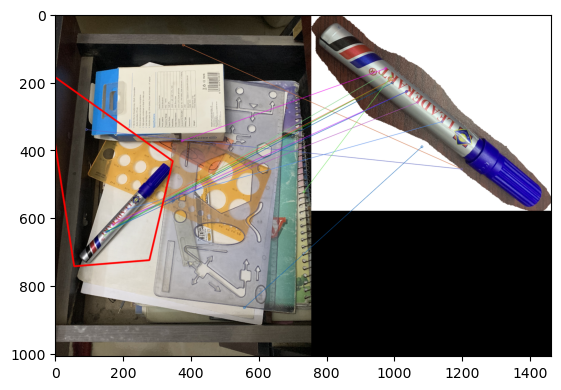

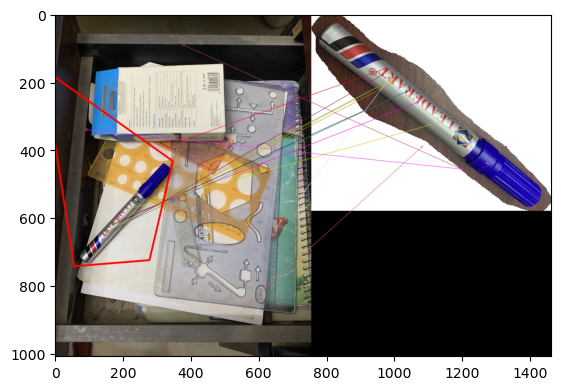

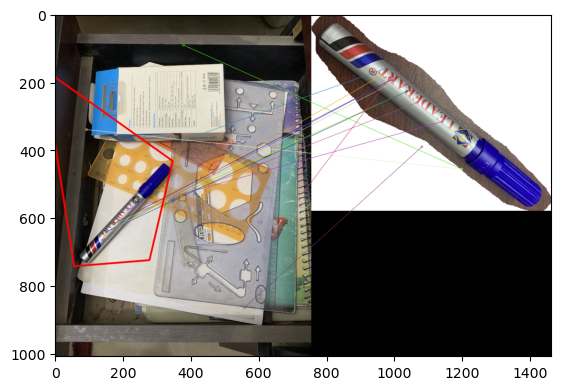

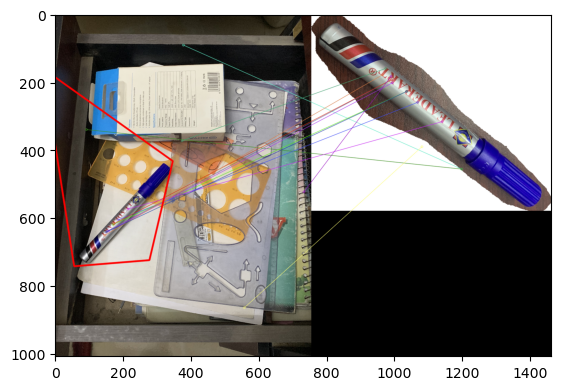

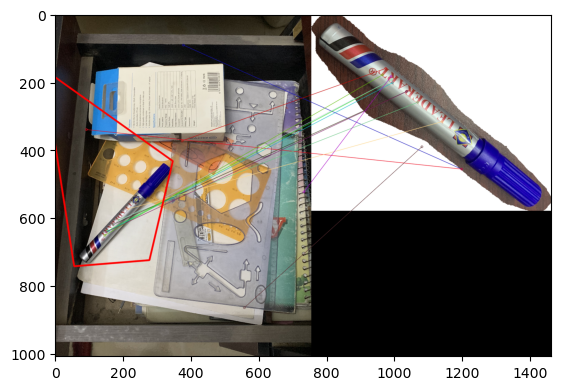

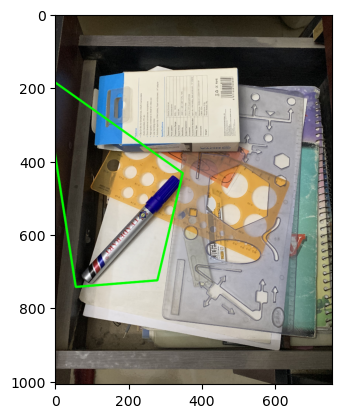

In [178]:
params = {
    "max_matching_objects": 5,
    "SIFT_distance_threshold": 0.65,
    "best_matches_points": 50,
}

matched_boxes = find_matching_boxes(lost_found_box, template, "SIFT", params)

# Draw the bounding boxes on the original image
for box in matched_boxes:
    cv2.polylines(lost_found_box, [np.int32(box)], True, (0, 255, 0), 3, cv2.LINE_AA)

plt.imshow(lost_found_box)
plt.show()

In [179]:
if len(matched_boxes) > 0:
    print("Found the lost object")
else:
    print("Lost object not found")

Found the lost object


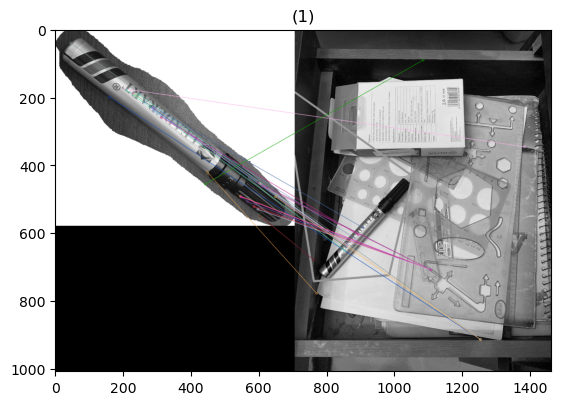

In [180]:
applySift(template, lost_found_box)